In [182]:
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import scipy as sp
from pylab import *
from networkx.drawing.nx_pydot import graphviz_layout
from networkx.algorithms import bipartite
import random as rd
from collections import Counter
import pylab 
import scipy.stats as stats
import warnings
import matplotlib.animation as animation
import os


warnings.filterwarnings('ignore')


In [183]:
#Function for drawing radial graphs in NetworkX library
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
    
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos

            
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

In [184]:
#Counting the number of clusters and composition of cluster (cells per cluster)
def module_counter():
    global g
    cluster_counter=0
    for e in g.edges():
        if(g.edges[e[0],e[1]]['break']==0):
            cluster_counter=cluster_counter+1
            for n in g.nodes():
                if(n.endswith(e[1][1:])):
                    g.nodes[n]['clust']=str(cluster_counter)

In [185]:
#Calculation of Kullback-Leibler Divergence between the experimental and model derived distribution
def KL(a, b):
    a = np.asarray(a, dtype=np.float)
    b = np.asarray(b, dtype=np.float)
    return np.sum(np.where(a != 0, a * np.log(a / b), 0))

In [186]:
#Count the distribution of number of cells per cluster
def count_freq(g):
    clust_information=[]
    for n in g.nodes():
        clust_information.append(g.nodes[n]['clust'])
    a=Counter(clust_information)
    freq=list(a.values())
    return freq

In [187]:
def graph_snap(t,sim_time):
    for n in g.nodes():
        g.nodes[n]['snap_time']=int(str(n)[1])
    for e in g.edges():
        if(g.edges[e[0],e[1]]['break']==1):
            g.edges[e[0],e[1]]['snap_time']=int(e[1][1])-1
        else:
            g.edges[e[0],e[1]]['snap_time']=sim_time

In [188]:

def break_cluster_sa(t,max_node):
    global g
    cluster_counter=0
    degree_list=[]
    
    for e in g.edges():
        if(t>=g.edges[e[0],e[1]]['t_break'] and (g.edges[e[0],e[1]]['break']!=0)):
            g.edges[e[0],e[1]]['break']=0

    node_list=[node for node in g.nodes()]
    for node in node_list:
        edges_temp=g.edges(node)
        break_list=[g.edges[ed[0],ed[1]]['break'] for ed in edges_temp]
        degree_list.append(sum(break_list))
    max_nodes = [node_list[i] for i, x in enumerate(degree_list) if x == max(degree_list)]
    max_degrees = [degree_list[i] for i, x in enumerate(degree_list) if x == max(degree_list)]
    
    for i,node in enumerate(max_nodes):
        if(max_degrees[i]>=max_node):
            edges=[edge for edge in g.edges(node) if g.edges[edge[0],edge[1]]['break']!=0]
            edge_bt=[g.edges[e[0],e[1]]['t_break'] for e in edges]
            for k,bt in enumerate(edge_bt): 
                if(np.round(bt,0)>=t):
                    edge_tbb=edges[k]
                    g.edges[edge_tbb[0],edge_tbb[1]]['break']=0    

        

In [189]:
##This is model 1A in which there is only link breaking without any steric forces
def break_cluster_sr(t,max_node):
    global g
    cluster_counter=0
    degree_list=[]
    
    for e in g.edges():
        if(t>=g.edges[e[0],e[1]]['t_break']):
            g.edges[e[0],e[1]]['break']=0

    node_list=[node for node in g.nodes()]
    for node in node_list:
        edges_temp=g.edges(node)
        break_list=[g.edges[ed[0],ed[1]]['break'] for ed in edges_temp]
        degree_list.append(sum(break_list))
    max_nodes = [node_list[i] for i, x in enumerate(degree_list) if x == max(degree_list)]
    max_degrees = [degree_list[i] for i, x in enumerate(degree_list) if x == max(degree_list)]
    
    for i,node in enumerate(max_nodes):
        if(max_degrees[i]>=max_node):
            edges=[edge for edge in g.edges(node) if g.edges[edge[0],edge[1]]['break']!=0]
            edge_bt=[g.edges[e[0],e[1]]['t_break'] for e in edges]
            edge_select=rd.choice(edges)
            g.edges[edge_select[0],edge_select[1]]['break']=0

In [190]:
def grow(t,mbt):
    global g
    nextg=g.copy()
    for n in g.nodes():
        new_node='Y'+str(t)+'_'+str(n)[1:] #Naming daughter cells to track lineage information
        nextg.add_edge(str(n),new_node) #Growth
        nextg.nodes[new_node]['clust']=nextg.nodes[str(n)]['clust'] #Inherit the cluster information
        nextg.edges[str(n),new_node]['break']=1
        nextg.edges[str(n),new_node]['t_break']=t+np.random.exponential(scale=mbt)
    g=nextg



In [191]:
def init_system():
    global g
    g=nx.Graph() #Initialization 
    g.add_node('Y0') #Mother yeast cell 
    g.nodes['Y0']['clust']='0'
    nextg=g.copy()

In [192]:
#Main function to call other functions associated with dissociation of the cluster, counting of cells per custer
def clust_form_and_break(sim_time,max_node,mbt,dt,h):
    global g
    
    init_system()
    
    for t in range(sim_time):
        if(int(t%dt)==0): 
            grow(t,mbt)
        if(h==0):
            break_cluster_sa(t,max_node)
        else:
            break_cluster_sr(t,max_node)
            
        graph_snap(t,sim_time)
    
    module_counter()
    
    return g

### Data BUD4

In [193]:
cd /Users/piyushnanda/Documents/PhD_MurrayLab/EMC/Data/ePN002/BUD4_Repeat_2/counts_2/

/Users/piyushnanda/Documents/PhD_MurrayLab/EMC/Data/ePN002/BUD4_Repeat_2/counts_2


In [194]:
files=sorted(os.listdir())
counts=[]
count_data=pd.DataFrame()

for f in files:
    if('BUD4' in f):
        df=pd.read_csv(f)['cell_counts']
        count_data[f[7:f.index('.c')]]=df

# BUD4 OFF

CPU times: user 6.75 s, sys: 151 ms, total: 6.9 s
Wall time: 6.38 s


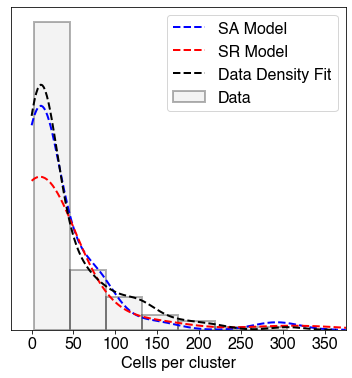

In [177]:
%%time
%matplotlib inline

kn=[8,5]
gr=[3,3]
be=['0','7.5']
xlim=[250,30]
bins=[50,50]
mbt=[100,32]
plt.rc('font',family='helvetica')
fig,ax=plt.subplots(nrows=2,ncols=1,figsize=(5,10))
t=['BUD4OFF','BUD4ON']
color=['blue','red']
color_var=[(0,0,1,0.1),(1,0,0,0.1)]

i=0
sim_time=int(gr[i]*10)
kissing_no=kn[i]
mean_breaking_time=mbt[i]
doubling_time=gr[i]
cv=[]

for h in [0,1]:
    
    for k in range(10):
        g=clust_form_and_break(sim_time,kissing_no,mean_breaking_time,doubling_time,h)
#         sns.kdeplot(np.array(count_freq(g)),color=color_var[h],linewidth=5,clip=(0,xlim[i]),ax=ax[i],cumulative=False)
        cv.append(np.std(count_freq(g))/np.mean(count_freq(g)))


    g=clust_form_and_break(sim_time,kissing_no,mean_breaking_time,doubling_time,h)
    sns.kdeplot(np.array(count_freq(g)),color=color[h],linestyle='--',linewidth=2,clip=(0,xlim[i]),ax=ax[i],cumulative=False)
    cv.append(np.std(count_freq(g))/np.mean(count_freq(g)))

ax[i].hist(count_data[be[i]],7,color=(0.1,0.1,0.1,0.05),cumulative=False,density=True,edgecolor=(0,0,0,0.3),linewidth=2)
sns.kdeplot(count_data[be[i]],color=(0,0,0,1),linestyle='--',linewidth=2,clip=(0,xlim[i]),ax=ax[i],cumulative=False)
cv.append(np.std(count_data[be[i]])/np.mean(count_data[be[i]]))

if(i==0):
    cv_ui=cv
else:
    cv_i=cv
ax[i].set_yticks([])
ax[i].set_ylabel('')
ax[0].set_xlabel('')
ax[i].legend(['SA Model','SR Model','Data Density Fit','Data'],fontsize=16)
ax[0].set_xlabel('')
ax[0].set_xlim(-10,150)
ax[1].set_xlim(-1.5,30)
ax[0].set_xticklabels([-50,0,50,100,150,200,250,300,350],fontsize=16)
ax[1].set_xticklabels([-20,0,10,20,30,40,50],fontsize=16)
ax[0].set_xlabel('Cells per cluster',fontsize=16)
ax[1].set_xlabel('Cells per cluster',fontsize=16)
fig.delaxes(ax[1-i])
fig.tight_layout()

fig.savefig('/Users/piyushnanda/Documents/PhD_MurrayLab/EMC/Figures/Final/Model2A_OFF.jpg',dpi=600)

# BUD4 ON

CPU times: user 7.26 s, sys: 348 ms, total: 7.61 s
Wall time: 7.08 s


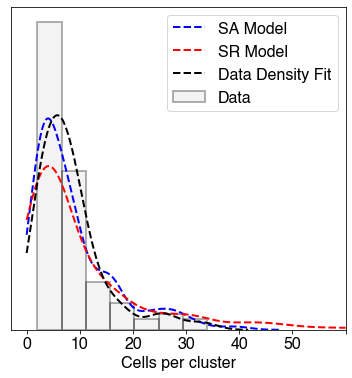

In [178]:
%%time
%matplotlib inline

kn=[8,5]
gr=[3,3]
be=['0','7.5']
xlim=[250,30]
bins=[10,10]
mbt=[100,32]
plt.rc('font',family='helvetica')
fig,ax=plt.subplots(nrows=2,ncols=1,figsize=(5,10))
t=['BUD4OFF','BUD4ON']
color=['blue','red']
color_var=[(0,0,1,0.075),(1,0,0,0.075)]

i=1
sim_time=int(gr[i]*10)
kissing_no=kn[i]
mean_breaking_time=mbt[i]
doubling_time=gr[i]
cv=[]

for h in [0,1]:
    
    for k in range(10):
        g=clust_form_and_break(sim_time,kissing_no,mean_breaking_time,doubling_time,h)
#         sns.kdeplot(np.array(count_freq(g)),color=color_var[h],linewidth=7.5,clip=(0,xlim[i]),ax=ax[i],cumulative=False)
        cv.append(np.std(count_freq(g))/np.mean(count_freq(g)))


    g=clust_form_and_break(sim_time,kissing_no,mean_breaking_time,doubling_time,h)
    sns.kdeplot(np.array(count_freq(g)),color=color[h],linestyle='--',linewidth=2,clip=(0,xlim[i]),ax=ax[i],cumulative=False)
    cv.append(np.std(count_freq(g))/np.mean(count_freq(g)))

ax[i].hist(count_data[be[i]],7,color=(0.1,0.1,0.1,0.05),cumulative=False,density=True,edgecolor=(0,0,0,0.3),linewidth=2)
sns.kdeplot(count_data[be[i]],color=(0,0,0,1),linestyle='--',linewidth=2,clip=(0,xlim[i]),ax=ax[i],cumulative=False)
cv.append(np.std(count_data[be[i]])/np.mean(count_data[be[i]]))

if(i==0):
    cv_ui=cv
else:
    cv_i=cv
ax[i].set_yticks([])
ax[i].set_ylabel('')
ax[0].set_xlabel('')
ax[i].legend(['SA Model','SR Model','Data Density Fit','Data'],fontsize=16)
ax[0].set_xlabel('')
ax[0].set_xlim(-10,150)
ax[1].set_xlim(-1.5,30)
ax[0].set_xticklabels([-50,0,50,100,150,200,250,300,350],fontsize=16)
ax[1].set_xticklabels([-20,0,10,20,30,40,50],fontsize=16)
ax[0].set_xlabel('Cells per cluster',fontsize=16)
ax[1].set_xlabel('Cells per cluster',fontsize=16)
fig.delaxes(ax[1-i])
fig.tight_layout()

fig.savefig('/Users/piyushnanda/Documents/PhD_MurrayLab/EMC/Figures/Final/Model2A_ON.jpg',dpi=600)

In [152]:
cv_vals=pd.DataFrame({'10 nM':cv_ui,'0 nM':cv_i})

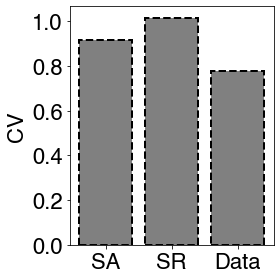

In [148]:
plt.rc('font',family='helvetica')
plt.figure(figsize=(4,4))
plt.bar(['SA','SR','Data'],cv_vals['0 nM'],color='gray',edgecolor='black',linewidth=2,linestyle='--')
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.ylabel('CV',fontsize=22)
plt.tight_layout()
# plt.savefig('/Users/piyushnanda/Documents/PhD_MurrayLab/EMC/Figures/Final/CV_SA_SR_0nM_Data.jpg',dpi=600)

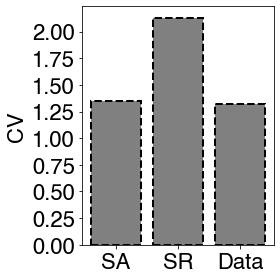

In [149]:
plt.rc('font',family='helvetica')
plt.figure(figsize=(4,4))
plt.bar(['SA','SR','Data'],cv_vals['10 nM'],color='gray',edgecolor='black',linewidth=2,linestyle='--')
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.ylabel('CV',fontsize=22)
plt.tight_layout()
# plt.savefig('/Users/piyushnanda/Documents/PhD_MurrayLab/EMC/Figures/Final/CV_SA_SR_10nM_Data.jpg',dpi=600)

## Cluster Statistics Experiment vs Simulations

In [24]:
f=pd.read_csv('/Users/piyushnanda/Documents/PhD_MurrayLab/EMC/Data/ePN002/stats_bud4_on_off.csv')

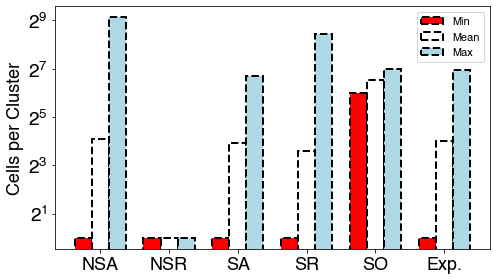

In [110]:
ind = np.arange(0,6)*1.33  
width = .33

plt.rc('font',family='helvetica')
plt.figure(figsize=(7,4))
plt.bar(ind-width, f['Min'][0:6], width,label='Min',color='red',edgecolor='black',linewidth=2,linestyle='--')
plt.bar(ind, f['Mean'][0:6], width,label='Mean',color='white',edgecolor='black',linewidth=2,linestyle='--')
plt.bar(ind+width, f['Max'][0:6], width,label='Max',color='lightblue',edgecolor='black',linewidth=2,linestyle='--')
plt.xticks(ind,['NSA','NSR','SA','SR','SO','Exp.'],fontsize=18)
plt.yticks(fontsize=19)
plt.legend(fontsize=11)
plt.ylabel('Cells per Cluster',fontsize=18)
plt.yscale('log',base=2)
plt.tight_layout()

plt.savefig('/Users/piyushnanda/Documents/PhD_MurrayLab/EMC/Figures/ON_Comparison.jpg',dpi=600)


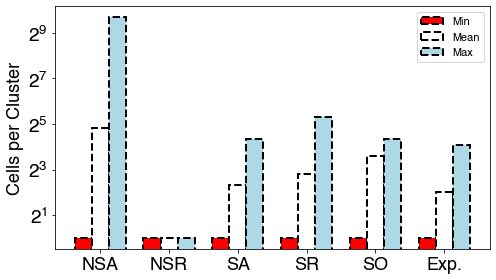

In [111]:
ind = np.arange(0,6)*1.33  
width = .33

plt.rc('font',family='helvetica')
plt.figure(figsize=(7,4))
plt.bar(ind-width, f['Min'][6:12], width,label='Min',color='red',edgecolor='black',linewidth=2,linestyle='--')
plt.bar(ind, f['Mean'][6:12], width,label='Mean',color='white',edgecolor='black',linewidth=2,linestyle='--')
plt.bar(ind+width, f['Max'][6:12], width,label='Max',color='lightblue',edgecolor='black',linewidth=2,linestyle='--')
plt.xticks(ind,['NSA','NSR','SA','SR','SO','Exp.'],fontsize=18)
plt.yticks(fontsize=19)
plt.legend(fontsize=11)
plt.ylabel('Cells per Cluster',fontsize=18)
plt.yscale('log',base=2)
plt.tight_layout()

plt.savefig('/Users/piyushnanda/Documents/PhD_MurrayLab/EMC/Figures/OFF_Comparison.jpg',dpi=600)